# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [10]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


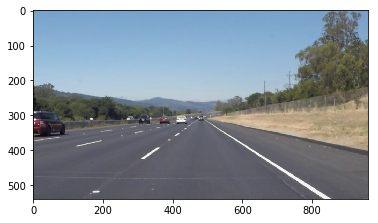

In [13]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [39]:
import math
from scipy.interpolate import interp1d
    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def mask_image(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    return mask


def region_of_interest(img, mask):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

def fitlines (img, lines, t, color=[255, 0, 0], thickness=5):
    
    ymax = img.shape[0]
    
    xakku = np.zeros(ymax)
    xcnt  = np.zeros(ymax)
    
    # collect line elements
    minangle = 0
    cnt = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            angle = np.arctan2(y2-y1,x2-x1)*180/np.pi
            
            if t==1:
                if angle > 0:
                    for y in range(y1, y2):
                        xakku[y] = xakku[y] + (x2-x1)/(y2-y1)*(y-y1) + x1
                        xcnt[y]  = xcnt[y] + 1
            else:
                if angle < 0:
                    for y in range(y2, y1):
                        xakku[y] = xakku[y] + (x2-x1)/(y2-y1)*(y-y1) + x1
                        xcnt[y]  = xcnt[y] + 1
       
    # fill polyfit array
    xpolyfit = []
    ypolyfit = []
    for y in range(0, ymax):
        if xcnt[y]>0:
            xpolyfit = np.append(xpolyfit, [xakku[y]/xcnt[y]])
            ypolyfit = np.append(ypolyfit, [y])
    
    # polyfit
    if xpolyfit == []:
        return 
    p = np.poly1d(np.polyfit(ypolyfit, xpolyfit, 2))
    
    # draw polynom
    ypolyval = np.arange(0, ymax).astype(np.int)
    xpolyval = np.round(np.polyval(p, ypolyval)).astype(np.int)
    yold = ypolyval[0]
    xold = xpolyval[0]
    #for n in range(ypolyval[0],np.size(ypolyval)):
    for n in range(0, ymax):
        if xpolyval[n] >= 0 and xpolyval[n]<img.shape[1] and ypolyval[n] < np.amax(ypolyfit):
            cv2.line(img, (xold, yold), (xpolyval[n], ypolyval[n]), color, thickness)
        xold = xpolyval[n]
        yold = ypolyval[n]   
        
            
def fitlines_spline (img, lines, t, color=[255, 0, 0], thickness=5):
    
    ymax = img.shape[0]
    
    xakku = np.zeros(ymax)
    xcnt  = np.zeros(ymax)
    
    # collect line elements
    minangle = 0
    cnt = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            angle = np.arctan2(y2-y1,x2-x1)*180/np.pi
            
            if t==1:
                if angle > 0:
                    for y in range(y1, y2):
                        xakku[y] = xakku[y] + (x2-x1)/(y2-y1)*(y-y1) + x1
                        xcnt[y]  = xcnt[y] + 1
            else:
                if angle < 0:
                    for y in range(y2, y1):
                        xakku[y] = xakku[y] + (x2-x1)/(y2-y1)*(y-y1) + x1
                        xcnt[y]  = xcnt[y] + 1
       
    # fill polyfit array
    xpolyfit = []
    ypolyfit = []
    for y in range(0, ymax):
        if xcnt[y]>0:
            xpolyfit = np.append(xpolyfit, [xakku[y]/xcnt[y]])
            ypolyfit = np.append(ypolyfit, [y])
    
    # polyfit
    if xpolyfit == []:
        return 
    s = interp1d(ypolyfit, xpolyfit, kind='cubic')
    
    # draw polynom
    ypolyval = np.arange(0, ymax).astype(np.int)
    #xpolyval = np.round(s(ypolyval)).astype(np.int)
    yold = ypolyval[0]
    #xold = xpolyval[0]
    #for n in range(ypolyval[0],np.size(ypolyval)):
    for n in range(0, ymax):
        #if xpolyval[n] >= 0 and xpolyval[n]<img.shape[1] and ypolyval[n] < np.amax(ypolyfit):
        cv2.line(img, (s(yold), yold), (s(ypolyval[n]), ypolyval[n]), color, thickness)
        #xold = xpolyval[n]
        yold = ypolyval[n]   
        
            


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, [255,255,255])
    fitlines(line_img, lines, 1, [255,0,0])
    fitlines(line_img, lines, 0, [0,255,0])
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, a=0.8, b=1., g=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, a, img, b, g)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

test_images/solidWhiteRight.jpg
test_images/solidYellowCurve.jpg
test_images/solidYellowLeft.jpg
test_images/solidWhiteCurve.jpg
test_images/whiteCarLaneSwitch.jpg
test_images/solidYellowCurve2.jpg


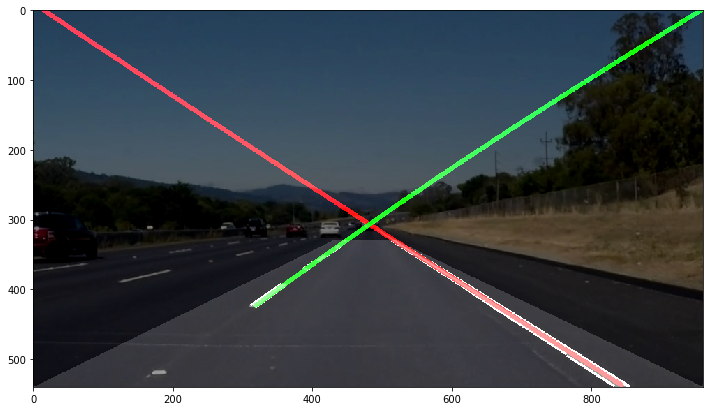

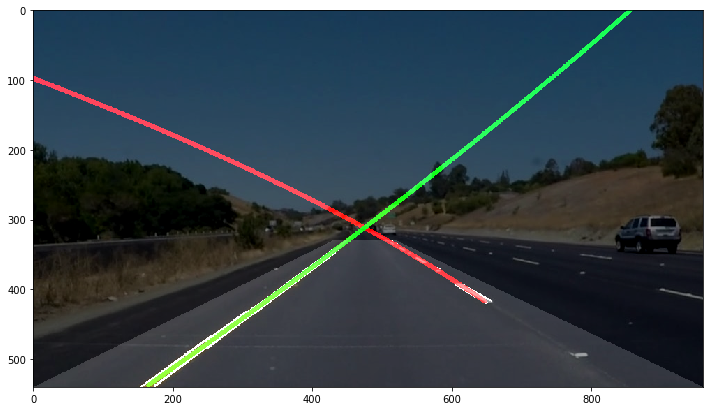

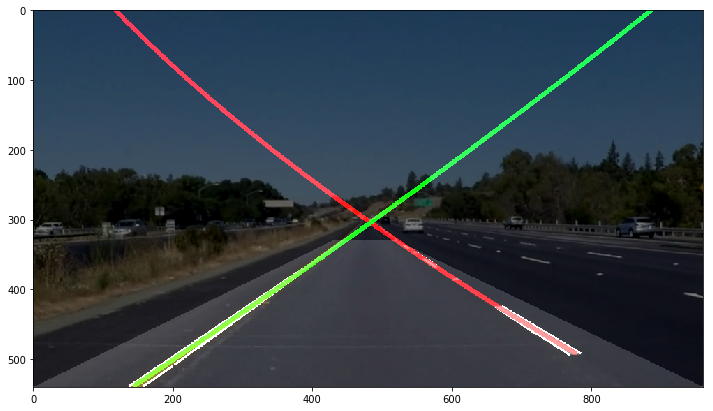

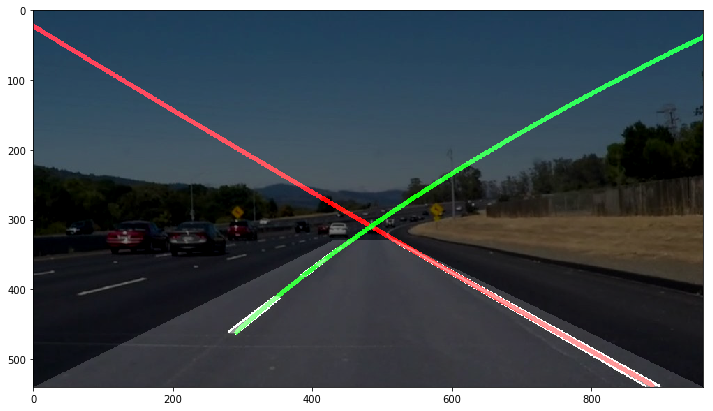

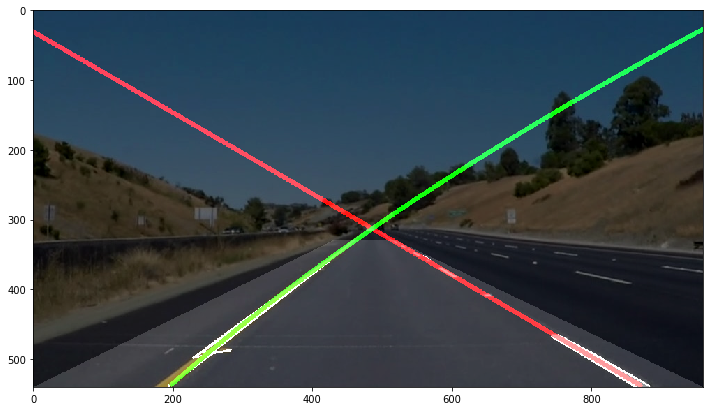

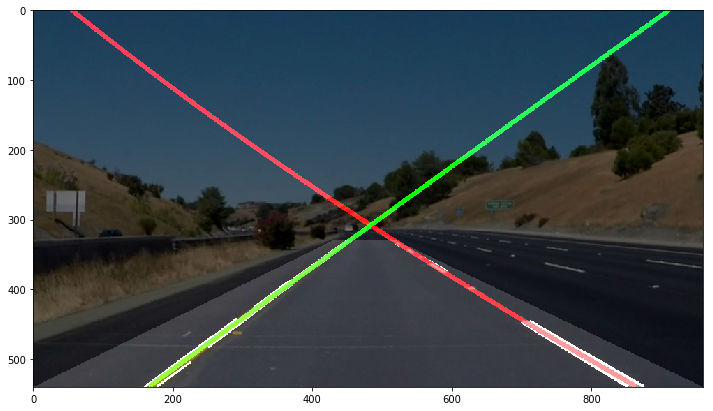

In [40]:
import os

VERBOSE = False
for img in os.listdir("test_images/"):
    if img.endswith('jpg'):
        print ('test_images/'+img)
        image = mpimg.imread('test_images/'+img)
        
        img = findLanes (image)
        
        plt.figure(figsize=(12,8))
        plt.imshow(img) 

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [41]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def findLanes (img):
    grayimg = grayscale (img)
    
    # bluring image
    kernel_size = 5
    blurimg = gaussian_blur (grayimg, kernel_size)
    
    # genertate edge image
    canny_low_thres = 50
    canny_high_thres= 150
    edgeimg = canny (blurimg, canny_low_thres, canny_high_thres) 
    
    # generate mask image
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]),(430, 330), (520, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    maskedimg = region_of_interest (edgeimg, mask_image(edgeimg, vertices))
    
    # detect lines
    houghimg = hough_lines(maskedimg, 2, np.pi/180, 15, 40, 20)
    
    maskimg = weighted_img (cv2.bitwise_not(mask_image(img, vertices)), img, b=-0.2)
    
    resimg = weighted_img (houghimg, maskimg)
    
    return resimg

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [5]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    result = findLanes(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [20]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:16<00:00, 13.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.54 s, sys: 96 ms, total: 5.64 s
Wall time: 18.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [25]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 37%|███▋      | 250/682 [00:24<00:52,  8.17it/s]


 75%|███████▌  | 512/682 [00:51<00:22,  7.64it/s]


100%|█████████▉| 681/682 [01:11<00:00,  6.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 19.2 s, sys: 332 ms, total: 19.5 s
Wall time: 1min 13s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [129]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

49.9392155421
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 2/251 [00:00<00:13, 18.50it/s]

49.9392155421
73.8865817669
53.5691418798


  2%|▏         | 4/251 [00:00<00:13, 18.35it/s]

50.063616853


  2%|▏         | 6/251 [00:00<00:13, 17.89it/s]

62.4471884233
42.1170365475
33.690067526


  3%|▎         | 8/251 [00:00<00:13, 17.72it/s]

50.3321588817


  4%|▍         | 10/251 [00:00<00:14, 16.73it/s]

34.9920201986
35.7889734592


  5%|▍         | 12/251 [00:00<00:14, 16.34it/s]

45.0
54.0276129507


  6%|▌         | 14/251 [00:00<00:14, 16.52it/s]

54.7275785514
54.462322208


  6%|▋         | 16/251 [00:00<00:14, 15.75it/s]

45.0
38.6598082541


  7%|▋         | 18/251 [00:01<00:14, 16.48it/s]

43.9949139947
67.9887168021


  8%|▊         | 20/251 [00:01<00:13, 16.66it/s]

48.0127875042
48.945186229


  9%|▉         | 22/251 [00:01<00:13, 16.47it/s]

43.2376089763
35.1664360358


 10%|▉         | 24/251 [00:01<00:13, 16.37it/s]

46.193489424
80.1664360358


 10%|█         | 26/251 [00:01<00:13, 16.55it/s]

46.9749340109
60.7247457227


 11%|█         | 28/251 [00:01<00:13, 16.46it/s]

48.7313969992
37.775684306


 12%|█▏        | 30/251 [00:01<00:13, 16.44it/s]

55.8230112262
41.5526131481


 13%|█▎        | 32/251 [00:01<00:13, 16.69it/s]

61.0323393539
56.8702645316


 14%|█▎        | 34/251 [00:02<00:12, 16.73it/s]

41.7845160083
75.7499673022


 14%|█▍        | 36/251 [00:02<00:12, 16.71it/s]

65.6589100633
64.1556124454


 15%|█▌        | 38/251 [00:02<00:12, 16.71it/s]

59.9816325724
71.2586595548


 16%|█▌        | 40/251 [00:02<00:12, 16.76it/s]

48.8140748343
82.3493490446


 17%|█▋        | 42/251 [00:02<00:12, 16.72it/s]

56.309932474
33.2065703151
62.1759036157


 18%|█▊        | 44/251 [00:03<00:25,  8.24it/s]

49.9697407281
77.6609127217


 18%|█▊        | 46/251 [00:03<00:24,  8.50it/s]

52.8152935468
56.0035408517


 19%|█▉        | 48/251 [00:03<00:25,  8.10it/s]

52.8290765101
61.8583987677


 20%|██        | 51/251 [00:03<00:23,  8.34it/s]

79.3302171955
87.4831243431
47.009553813

 21%|██        | 52/251 [00:04<00:28,  7.04it/s]


62.1027289691


 22%|██▏       | 54/251 [00:04<00:25,  7.81it/s]

53.5691418798
87.6626941409
76.6075022462


 23%|██▎       | 57/251 [00:04<00:31,  6.09it/s]

57.2647737279
82.4761795614


 24%|██▎       | 59/251 [00:05<00:31,  6.01it/s]

71.2413496522
87.9174347203


 24%|██▍       | 61/251 [00:05<00:33,  5.62it/s]

86.054813771
69.5901171662
83.1572265874


 25%|██▌       | 64/251 [00:06<00:29,  6.40it/s]

83.7965520983
88.0250659891


 26%|██▋       | 66/251 [00:06<00:25,  7.22it/s]

83.0317432586
78.1785116594
87.4362297885


 27%|██▋       | 69/251 [00:06<00:23,  7.64it/s]

81.1193408495
87.1375947739
47.1747441146


 28%|██▊       | 71/251 [00:06<00:21,  8.24it/s]

85.3893506813


 29%|██▉       | 74/251 [00:07<00:22,  8.00it/s]

87.4738830884
87.8789036033


 30%|██▉       | 75/251 [00:07<00:21,  8.10it/s]

87.1844433158
84.8055710923


 31%|███       | 78/251 [00:07<00:24,  6.95it/s]

86.15396991
85.91438322


 31%|███▏      | 79/251 [00:08<00:25,  6.84it/s]

85.6676860168
86.2359651351


 33%|███▎      | 82/251 [00:08<00:23,  7.07it/s]

86.3255004792
87.161212159


 33%|███▎      | 83/251 [00:08<00:23,  7.19it/s]

52.907162703
86.3477772197


 34%|███▍      | 86/251 [00:09<00:21,  7.58it/s]

86.8201698801
86.2173545534


 35%|███▍      | 87/251 [00:09<00:21,  7.74it/s]

86.8550425353
85.2363583093


 36%|███▌      | 90/251 [00:09<00:21,  7.58it/s]

88.6980473274
88.6360724684


 36%|███▋      | 91/251 [00:09<00:20,  7.64it/s]

86.2482709295
79.0888716157


 37%|███▋      | 94/251 [00:10<00:20,  7.71it/s]

89.0759546472
87.2072976343


 38%|███▊      | 95/251 [00:10<00:20,  7.58it/s]

81.8698976458
90.0


 39%|███▉      | 98/251 [00:10<00:20,  7.52it/s]

85.6839724801
81.6743496696


 39%|███▉      | 99/251 [00:10<00:19,  7.69it/s]

87.3974377975
86.0275040592


 41%|████      | 102/251 [00:11<00:19,  7.56it/s]

40.9464457682
67.2971578768


 41%|████      | 103/251 [00:11<00:19,  7.69it/s]

86.1859251657
82.1168606833


 42%|████▏     | 105/251 [00:11<00:21,  6.84it/s]

53.1301023542
60.7511736635


 43%|████▎     | 107/251 [00:12<00:20,  6.89it/s]

50.5275401517
50.6594818402


 44%|████▍     | 110/251 [00:12<00:20,  6.72it/s]

71.5650511771
88.9949139947


 44%|████▍     | 111/251 [00:12<00:20,  6.75it/s]

87.2736890061
83.0189425932


 45%|████▌     | 113/251 [00:13<00:22,  6.00it/s]

86.2686030008
85.2852454813


 46%|████▌     | 115/251 [00:13<00:20,  6.64it/s]

69.8293465881
67.619864948


 47%|████▋     | 117/251 [00:13<00:22,  5.83it/s]

87.5633517532
69.7174409111


 47%|████▋     | 119/251 [00:14<00:20,  6.34it/s]

70.5599651718
86.054813771


 48%|████▊     | 121/251 [00:14<00:22,  5.69it/s]

73.4126614431
82.1998121158


 49%|████▉     | 123/251 [00:14<00:20,  6.19it/s]

81.7028550302
85.2363583093


 50%|████▉     | 125/251 [00:15<00:22,  5.49it/s]

43.8982938848
41.1120904392


 51%|█████     | 127/251 [00:15<00:20,  6.00it/s]

42.1375947739
87.7093899574


 51%|█████▏    | 129/251 [00:15<00:22,  5.51it/s]

46.1233027141
88.090847567


 52%|█████▏    | 131/251 [00:16<00:19,  6.12it/s]

88.5679038158
81.4692343901


 53%|█████▎    | 133/251 [00:16<00:21,  5.60it/s]

39.7099187946
40.3645365731


 54%|█████▍    | 135/251 [00:16<00:18,  6.13it/s]

84.0938588862
70.8209919742


 55%|█████▍    | 138/251 [00:17<00:16,  6.73it/s]

83.4180553448
87.9545915111


 55%|█████▌    | 139/251 [00:17<00:16,  6.84it/s]

34.9920201986
53.3256503304


 57%|█████▋    | 142/251 [00:17<00:15,  7.02it/s]

31.7014296695
33.0916999387


 57%|█████▋    | 143/251 [00:18<00:15,  7.13it/s]

69.5901171662
68.7494944929


 58%|█████▊    | 146/251 [00:18<00:14,  7.04it/s]

52.3737663613
55.0079798014


 59%|█████▊    | 147/251 [00:18<00:14,  7.03it/s]

32.9492151166
63.4349488229


 59%|█████▉    | 149/251 [00:19<00:17,  5.98it/s]

44.2747757009
38.9909940425


 60%|██████    | 151/251 [00:19<00:15,  6.54it/s]

45.0
30.1600608381


 61%|██████    | 152/251 [00:19<00:17,  5.69it/s]

31.1849746587


 61%|██████▏   | 154/251 [00:19<00:18,  5.30it/s]

47.070030653
46.0230301887


 62%|██████▏   | 155/251 [00:20<00:19,  5.00it/s]

45.7252242991


 63%|██████▎   | 158/251 [00:20<00:17,  5.27it/s]

43.6028189727
42.9398889763


 63%|██████▎   | 159/251 [00:20<00:15,  5.81it/s]

42.1375947739
40.3645365731


 64%|██████▍   | 161/251 [00:21<00:15,  5.91it/s]

39.1439864146
36.8698976458


 65%|██████▍   | 163/251 [00:21<00:13,  6.49it/s]

37.0424747731
38.3674853849


 66%|██████▌   | 166/251 [00:22<00:12,  6.73it/s]

45.0
38.0470425318


 67%|██████▋   | 167/251 [00:22<00:12,  6.99it/s]

43.8465495489
36.8698976458


 68%|██████▊   | 170/251 [00:22<00:11,  6.93it/s]

33.8869594641
32.0740008753


 68%|██████▊   | 171/251 [00:22<00:11,  7.05it/s]

37.1042349057
36.8698976458


 69%|██████▉   | 173/251 [00:23<00:12,  6.28it/s]

34.2490330068
33.690067526


 70%|██████▉   | 175/251 [00:23<00:10,  6.95it/s]

38.6598082541
38.9909940425


 71%|███████   | 177/251 [00:23<00:11,  6.38it/s]

37.4505782317
32.0053832081


 71%|███████▏  | 179/251 [00:24<00:10,  6.89it/s]

36.7241071729
40.6839724801


 72%|███████▏  | 181/251 [00:24<00:10,  6.43it/s]

45.6902771979
36.8698976458


 73%|███████▎  | 183/251 [00:24<00:09,  6.95it/s]

37.0824969652
41.8550425353


 74%|███████▎  | 185/251 [00:24<00:10,  6.38it/s]

53.1301023542
54.1178627538


 75%|███████▍  | 187/251 [00:25<00:09,  7.06it/s]

55.8138775136
45.0


 75%|███████▌  | 189/251 [00:25<00:09,  6.78it/s]

47.070030653
44.1574757393


 76%|███████▋  | 192/251 [00:26<00:08,  6.61it/s]

43.22853026
37.8749836511


 77%|███████▋  | 193/251 [00:26<00:08,  6.67it/s]

53.4985588795
55.2440874465


 78%|███████▊  | 195/251 [00:26<00:08,  6.81it/s]

73.7798063044
42.0643265536


 78%|███████▊  | 197/251 [00:26<00:09,  5.73it/s]

39.130399557
45.0


 79%|███████▉  | 199/251 [00:27<00:08,  5.86it/s]

38.3674853849
41.9335144989


 80%|████████  | 202/251 [00:27<00:06,  7.15it/s]

41.8939729044
37.0303896057


 81%|████████  | 203/251 [00:27<00:07,  6.00it/s]

36.0982839671
53.9726266149


 82%|████████▏ | 206/251 [00:28<00:06,  7.33it/s]

38.4373014911
35.4170552765


 82%|████████▏ | 207/251 [00:28<00:06,  6.56it/s]

69.5901171662
36.0850730429


 84%|████████▎ | 210/251 [00:28<00:05,  7.48it/s]

45.0
41.9872124958


 84%|████████▍ | 211/251 [00:29<00:05,  6.68it/s]

42.1375947739
50.063616853


 85%|████████▍ | 213/251 [00:29<00:05,  7.50it/s]

40.0607844579
46.3971810273
33.3663660011


 86%|████████▋ | 217/251 [00:29<00:04,  8.17it/s]

35.0594269669
42.9786350596


 87%|████████▋ | 218/251 [00:29<00:04,  8.20it/s]

33.690067526
37.0565281894


 88%|████████▊ | 221/251 [00:30<00:03,  7.86it/s]

32.7842808659
46.0809241867


 88%|████████▊ | 222/251 [00:30<00:03,  8.03it/s]

78.1785116594
44.0122396004


 90%|████████▉ | 225/251 [00:30<00:03,  7.96it/s]

69.5901171662
71.1468412356


 90%|█████████ | 226/251 [00:30<00:03,  8.03it/s]

85.8150838749
48.2892426785


 91%|█████████ | 229/251 [00:31<00:02,  7.89it/s]

41.8201698801
52.4958576397


 92%|█████████▏| 230/251 [00:31<00:02,  7.95it/s]

33.9590598197
36.3044971226


 93%|█████████▎| 233/251 [00:31<00:02,  7.79it/s]

35.7273982228
44.4437477729


 93%|█████████▎| 234/251 [00:32<00:02,  7.84it/s]

39.6678411183
41.9872124958


 94%|█████████▍| 236/251 [00:32<00:02,  7.30it/s]

37.092837297
38.0470425318
36.8698976458


 95%|█████████▌| 239/251 [00:32<00:01,  7.11it/s]

61.990823292
48.3664606634


 96%|█████████▋| 242/251 [00:33<00:01,  8.21it/s]

31.5347919052
31.1224701968


 97%|█████████▋| 243/251 [00:33<00:01,  7.09it/s]

44.2747757009
87.510447078


 98%|█████████▊| 246/251 [00:33<00:00,  7.62it/s]

43.0694125588
43.0694125588


 98%|█████████▊| 247/251 [00:33<00:00,  6.80it/s]

35.3112134396
38.8844964337


100%|█████████▉| 250/251 [00:34<00:00,  7.94it/s]

36.9952711427
37.9716037611
59.8264799704


100%|██████████| 251/251 [00:34<00:00,  5.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5 s, sys: 264 ms, total: 5.26 s
Wall time: 37.5 s


In [130]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))